# User Interface
Inside this node it is implemented the user interface that allows for deciding the linear and angular velocity of the robot, to start and stop the random position behaviour, to directly command the behaviour of the robot by forcing it to go straight, backwards, turning clock-wise or counterclock-wise. It also allows to show some informations about the state of the robot such as the linear and angular velocity (set and actual), the current position and orientation of the robot, the number of goal reached and cancelled, the time to reach each goal. 

## How To Run the code
First it is needed to have the simulation running. In one terminal go inside the workspace and write:
- roslaunch rt2_assignment1 sim.launch

In another terminal: go inside the rt2_assignment1 /noteboook and run:
- jupyter noteboook

Once it opens inside the file user_interface run each block.\
It is recommended to run them in order since some declarations present in early blocks are needed to run other blocks.

## Code

### Libraries
This block is needed to import the needed libraries.

In [1]:
import rospy
import time
import jupyros as jr
import matplotlib
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import math
import actionlib
import actionlib.msg

%matplotlib widget

from matplotlib.animation import FuncAnimation
from nav_msgs.msg import Odometry
from matplotlib import animation, rc
from std_msgs.msg import String, Float64, Bool, Float32
from rt2_assignment1.srv import Command
from ipywidgets import interact,interactive,fixed,interact_manual
from geometry_msgs.msg import Twist

### Initialization
This block is needed to inizialize the ros node, the server /user_interface and the publishers on the topics /vel and /cmd_vel

In [2]:
rospy.init_node('user_interface')
ui_client=rospy.ServiceProxy('/user_interface', Command)
pub_vel=rospy.Publisher('/vel', Twist, queue_size=1)
pub_cmd=rospy.Publisher('/cmd_vel', Twist, queue_size=1)

### Global Variables
In this block are declared all the variables needed in the code, they are divided in global variables needed to implement the robot behaviour and global variables needed to display informations

In [3]:
# robot behaviour
go_rand= True # wheater the robot is going random or not
vel=Twist() # the value of linear and angular velocities
cmd=Twist() # the command velocities I want to obtain
# display information
initial_time=time.time() # time at the beginning of the program
VelLin_s=0 # linear velocity requested
VelLin_a=0 # linear velocity actual
VelAng_s=0 # angular velocity requested
VelAng_a=0 # angular velocity actual
timeNow=0 # current time
time1=[]  # array to save the times
vel1_1=[] # array to save the linear velocities requested 
vel1_2=[] # array to save the actual linear velocities
vel2_1=[] # array to save the angular velocities requested
vel2_2=[] # array to save the actual angular velocities
x_data=[] # array to save the x coordinate of the robot
y_data=[] # array to save the y coordinate of the robot
stats = [0,0] #array to save the number of reached and cancelled goal
reached=0 #number of reached goals
cancelled=0 # number of cancelled goals
time_to_reach=[] #array to save the times to reach a goal
dx=0.0 #x direction of the orientation
dy=1.0 #y direction of the orientation

### Functions for buttons
In this block are defined all of the functions that are called when a buttons clicked or when the slider is moved.

In [4]:
# this function is called when the button start random behaviour is clicked
def start_rand(b):
    global go_rand
    go_rand=True
    # it sends 'start' as a request to the server
    ui_client('start')
    
# this function is called when the button stop random behaviour is clicked    
def stop_rand(b):
    global go_rand
    go_rand=False
    # it sends 'stop' as a request to the server cancelling the goal
    ui_client('stop')
    
# this function is called when the button to go straight ahead is clicked     
def up(b):
    global go_rand
    global vel,cmd
    # If the robot was moving towards a random goal 
    if go_rand:
        go_rand=False
        # it sends 'stop' as a request to the server cancelling the goal
        ui_client('stop')
    # all velocities are set to zero   
    stop_cmd(1)
    # I set the velocity I want
    cmd.linear.x=vel.linear.x
    # sleep 1 second
    time.sleep(1)
    #publish the velocity on the /cmd_vel topic
    pub_cmd.publish(cmd)

# this function is called when the button to go straight backwards is clicked     
def down(b):
    global go_rand,vel
    # If the robot was moving towards a random goal 
    if go_rand:
        go_rand=False
        # it sends 'stop' as a request to the server cancelling the goal
        ui_client('stop')
    # all velocities are set to zero    
    stop_cmd(1)
    # I set the velocity I want
    cmd.linear.x=-vel.linear.x
    # sleep 1 second
    time.sleep(1)
    #publish the velocity on the /cmd_vel topic
    pub_cmd.publish(cmd)
    
# this function is called when the button to turn left is clicked    
def left(b):
    global go_rand
    # If the robot was moving towards a random goal 
    if go_rand:
        go_rand=False
        # it sends 'stop' as a request to the server cancelling the goal
        ui_client('stop')
    # all velocities are set to zero    
    stop_cmd(1)
    # I set the velocity I want
    cmd.angular.z=-vel.angular.z
    # sleep 1 second
    time.sleep(1)
    #publish the velocity on the /cmd_vel topic
    pub_cmd.publish(cmd)
    
# this function is called when the button to turn right is clicked    
def right(b):
    global go_rand
    # If the robot was moving towards a random goal 
    if go_rand:
        go_rand=False
        # it sends 'stop' as a request to the server cancelling the goal
        ui_client('stop')
    # all velocities are set to zero    
    stop_cmd(1)
    # I set the velocity I want
    cmd.angular.z=vel.angular.z
    # sleep 1 second
    time.sleep(1)
    #publish the velocity on the /cmd_vel topic
    pub_cmd.publish(cmd)
    
# this function is called when the button to stop the manuall control is clicked 
def stop_cmd(b):
    global vel
    # sets all velocities to zero
    cmd.linear.x=0
    cmd.angular.z=0
    #publish the velocity on the /cmd_vel topic
    pub_cmd.publish(cmd)
    
# this function is called when the linear velocity slider is moved   
def setvellin(x):
    global vel
    # set the linear velocity to the same value of the slider
    vel.linear.x=x
    #publish the velocity on the /vel topic
    pub_vel.publish(vel)
    return x

# this function is called when the angular velocity slider is moved 
def setvelang(x):
    global go_rand
    global vel
    # set the angular velocity to the same value of the slider
    vel.angular.z=x
    #publish the velocity on the /vel topic
    pub_vel.publish(vel)
    return x

### Buttons style
In this block I initialized all the buttons' style and properties

In [5]:
# button to start the random goal behaviour
b1=widgets.Button(
                description='Start rand', 
                layout=widgets.Layout(widht='auto',grid_area='b1'),
                style=widgets.ButtonStyle(button_color='green')   
                )

#button to stop the random goal behaviour
b2 = widgets.Button(description='Stop rand',
                    layout=widgets.Layout(width='auto', grid_area='b2'),
                    style=widgets.ButtonStyle(button_color='red')
                    )

#button to go straight forward
b3 = widgets.Button(description='up',
                    layout=widgets.Layout(width='auto', grid_area='up'),
                    style=widgets.ButtonStyle(button_color='yellow')
                   )

#button to go straight backwards
b4 = widgets.Button(description='down',
                    layout=widgets.Layout(width='auto', grid_area='down'),
                    style=widgets.ButtonStyle(button_color='yellow')
                   )

#button to turn left
b5= widgets.Button(description='left',
                    layout=widgets.Layout(width='auto', grid_area='left'),
                    style=widgets.ButtonStyle(button_color='yellow')
                  )

#button to turn right
b6 = widgets.Button(description='right',
                    layout=widgets.Layout(width='auto', grid_area='right'),
                    style=widgets.ButtonStyle(button_color='yellow')
                   )

#button to stop manually moving the robot
b7 = widgets.Button(description='Stop',
                    layout=widgets.Layout(width='auto', grid_area='b7'),
                    style=widgets.ButtonStyle(button_color='orange')
                   )

### Buttons' Functions
In this block I associate each button with its function declared above. The function is called when the button is clicked once.

In [6]:
b1.on_click(start_rand)
b2.on_click(stop_rand)
b3.on_click(up)
b4.on_click(down)
b5.on_click(left)
b6.on_click(right)
b7.on_click(stop_cmd)

### Subscribers
In this block I initialize all of the subscribers needed to obtain the data to display in th graphs below. There are also functions needed to elaborate those data.\
Even though I have a subscriber for the command velocity I decided to add the requested velocities in the odom callback since If manually moving the robot the command velocity is called only once at the beginning, this would have caused the graph to not update at the same speed as the one for the actual velocities. I then save the value read from the /cmd_vel subscriber in a global variable and read them every time the odom callback is called.\
I set 500 as the maximum dimension of the arrays containing the time, the velocitis and the position.\
I haven't set a maximum dimension for the time to reach a goal since it would take a long time to reach big enough dimensions and also it would lose the purpose of understanding the statistics of it.

In [7]:
# this function transforms an angle in the interval [-pi, pi]
def normalize_angle(angle):
    if(math.fabs(angle) > math.pi):
        angle = angle - (2 * math.pi * angle) / (math.fabs(angle))
    return angle

#Convert a quaternion into euler angles (roll, pitch, yaw)
def euler_from_quaternion(x, y, z, w):
        #roll is rotation around x in radians (counterclockwise)
        #pitch is rotation around y in radians (counterclockwise)
        #yaw is rotation around z in radians (counterclockwise)
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians

# called when new data are published on the topic /odom
def odom_callback(msg):
    global timeNow, vel1_1, vel2_1, vel1_2, vel2_2, time1,dx,dy
    # retrieve how much time has passed between the init of the program
    timeNow= time.time()-initial_time
    # If I saved more than 500 data I delete the first one, for all arrays
    #I want arrays of maxium 500 elements to have a faster program
    if len(time1)>500:
        time1.pop(0)
        x_data.pop(0)
        y_data.pop(0)
        vel1_1.pop(0)
        vel1_2.pop(0)
        vel2_1.pop(0)
        vel2_2.pop(0)
    #add the new time 
    time1.append(timeNow)
    # add the new x position
    x_data.append(msg.pose.pose.position.x)
    # add the new y position
    y_data.append(msg.pose.pose.position.y)
    # add the new linear velocity actual
    vel1_2.append(msg.twist.twist.linear.x)
    # add the new angular velocity actual
    vel2_2.append(msg.twist.twist.angular.z)
    # add the new requested linear velocity
    vel1_1.append(VelLin_s)
    # add the new requested angular velocity
    vel2_1.append(VelAng_s)
    # Reading the quaternion to obtain the orientation of the robot
    quaternion = (
        msg.pose.pose.orientation.x,
        msg.pose.pose.orientation.y,
        msg.pose.pose.orientation.z,
        msg.pose.pose.orientation.w)
    # converting in Euler angles
    euler = euler_from_quaternion(quaternion[0],quaternion[1],quaternion[2],quaternion[3])
    # obtaining the angle of rotation about the z axis, it's positive value is counterclock-wise
    yaw_ = euler[2]
    # normalizing the yaw angle
    normalized_yaw=normalize_angle(yaw_)
    #obtaining the x and y components of an array representing orientation
    dx=math.cos(normalized_yaw)
    dy=math.sin(normalized_yaw)
    
# called when new data are published on the topic /cmd_vel
def vel_callback(msg):
    global VelLin_s, VelAng_s
    # saving the values of the requested velocities in global variables
    VelLin_s=msg.linear.x
    VelAng_s=msg.angular.z
    
# called when new data are published on the topic /reach
def reach_callback(msg):
    global reached,cancelled,stats
    # If the message is True the goal was reached and I need to add 1 to the global variables reached
    if msg.data:
        reached+=1
    # If the message is Flse I need to add 1 to the cancelled variable
    else: 
        cancelled+=1
    # updating the vector storing the data    
    stats=[reached, cancelled]

# called when new data are published on the topic /time   
def time_callback(msg):
    global time_to_reach
    # I add the time to reach the goal to the vector storing those information
    time_to_reach.append(msg.data)    

# declaring all of the subscribers    
vel_sub= rospy.Subscriber('/cmd_vel',Twist, vel_callback)    
sub= rospy.Subscriber('/odom',Odometry, odom_callback)
reach_sub= rospy.Subscriber('/reach',Bool, reach_callback) 
time_sub= rospy.Subscriber('/time',Float32, time_callback) 

### Buttons and Sliders
In this block I implemented the sliders and the buttons. I put the sliders on top and then under them a grid containing all of the needed buttons.\
The first slider on top is the one controlling the magnitude of the linear velocity. The slider below controls the magnitude of the angular velocity.\
The two buttons, the green and the red one, on the upper left corner starts and stop the random position behaviour.\
The yellow buttons on the bottom right corner manually controls the robot: the button Up moves the robot in a straight line forward, the button down moves the robot in a straight line backwards, the button right turns the robto clock-wise and the button left moves the robot counterclock-wise. The orange button stops the robot if it was moving manually, it has no effect on the random position behaviour other then briefly setting the velocities to zero.

In [8]:
print("Linear Velocity")
# slider for the linear velocity
interact(setvellin,
        x=widgets.FloatSlider(min=0.0, max=1, step=0.01, value=0.3))
print("Angular Velocity")
#slider for the angular velocity
interact(setvelang,
        x=widgets.FloatSlider(min=0.0, max=1, step=0.01, value=0.3))

# box to set all of the buttons
widgets.GridBox(children=[b1, b2, b3, b4, b5, b6, b7],
                layout=widgets.Layout(width='80%',grid_template_rows='auto auto auto',
                grid_template_columns='16% 16% 16% 16% 16% 16% ',
                grid_template_areas='''". . . b7  . .""b1 b2 . . up . "" . .  . left down right "''')
               )

Linear Velocity


interactive(children=(FloatSlider(value=0.3, description='x', max=1.0, step=0.01), Output()), _dom_classes=('w…

Angular Velocity


interactive(children=(FloatSlider(value=0.3, description='x', max=1.0, step=0.01), Output()), _dom_classes=('w…

GridBox(children=(Button(description='Start rand', layout=Layout(grid_area='b1'), style=ButtonStyle(button_col…

### Velocities
In the following two plots I have represented the linear and angular velocity both requested and real. In the first one I have the linear velocities and in the second one the angular velocities. On both plots in red the actual velocity and in green the requested velocity.\
We can notice than for the linear velocity the actual velocity is not really different from the requested one, we have a bit of delay in the actuation and we have some oscillations in the beginning but the values are similar. For the angular velocity though we notice that the sign is the opposite and also the magnitude is different, it is about half in absolute value. We can also notice a lot more oscillations and delays.\
The sign is the opposite because the /cmd_vel has as positive a clockwise-rotation whil odom has as positive a counterclock-wise rotation.

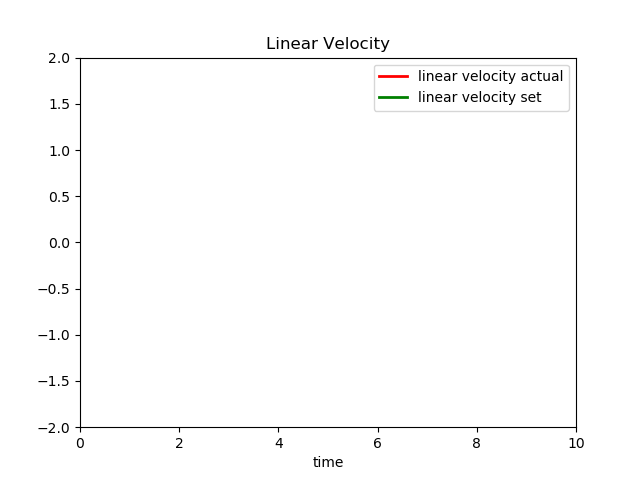

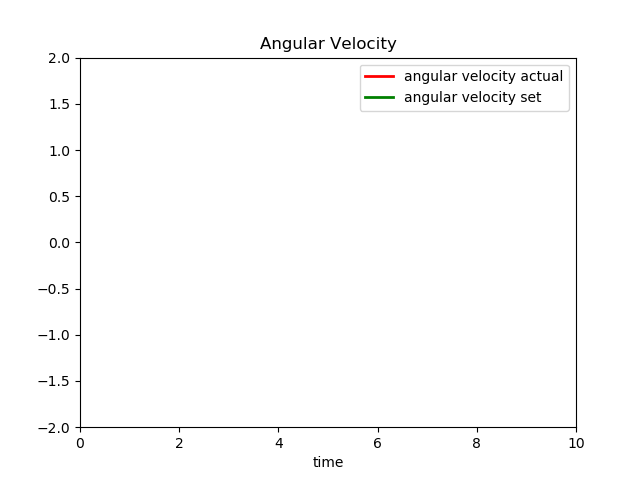

In [9]:
# setting the first plot
fig1,ax1=plt.subplots()
ax1.set_ylim((-2,2))
ax1.set_xlim((0,10))
lobj2 =ax1.plot([],[],lw=2, color='red',label='linear velocity actual')[0]
lobj1 =ax1.plot([],[], lw=2, color='green',label='linear velocity set')[0]
line1,=ax1.plot([],[], lw=2)
ax1.legend()
ax1.set_title("Linear Velocity")
ax1.set_xlabel('time')
lines1=[]
lines1.append(lobj1)
lines1.append(lobj2)

# setting the fsecond plot
fig2,ax2=plt.subplots()
ax2.set_ylim((-2,2))
ax2.set_xlim((0,10))
lobj2 =ax2.plot([],[],lw=2, color='red',label='angular velocity actual')[0]
lobj1 =ax2.plot([],[], lw=2, color='green',label='angular velocity set')[0]
line2,=ax2.plot([],[], lw=2)
ax2.legend()
ax2.set_title("Angular Velocity")
ax2.set_xlabel('time')
lines2=[]
lines2.append(lobj1)
lines2.append(lobj2)

# function called to initialize the plot
def init1():
    line1.set_data([],[])

# function called to initialize the plot    
def init2():
    line2.set_data([],[])

# function called to update periodically the plot
def animate1(i):
    ax1.set_xlim((timeNow-5,timeNow+5))
    xlist = [time1, time1]
    ylist = [vel1_1, vel1_2]
    #for index in range(0,1):
    for lnum1,line1 in enumerate(lines1):
        line1.set_data(xlist[lnum1], ylist[lnum1]) # set data for each line separately.
    return (lines1)

# function called to update periodically the plot
def animate2(i):
    ax2.set_xlim((timeNow-5,timeNow+5))
    xlist = [time1, time1]
    ylist = [vel2_1, vel2_2]
    #for index in range(0,1):
    for lnum2,line2 in enumerate(lines2):
        line2.set_data(xlist[lnum2], ylist[lnum2]) # set data for each line separately.
    return (lines2)

ani1=animation.FuncAnimation(fig1, animate1, init_func=init1, frames=100, interval=100, blit=True)
ani2=animation.FuncAnimation(fig2, animate2, init_func=init2, frames=100, interval=100, blit=True)


### Reached and Cancelled
In this graph I have two bars, the one on the left that represents the reached goals and the one on the right that represents the cancelled goals. 

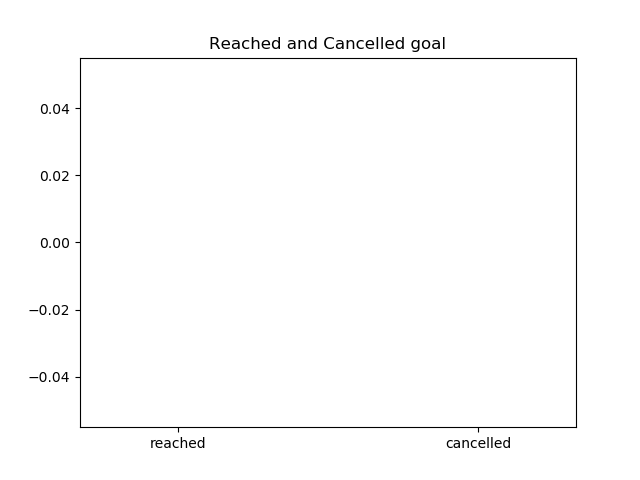

In [10]:
# setting the figure properties
fig3,ax3 = plt.subplots()
legend = ['reached', 'cancelled']
ax3.bar(legend,stats,color = 'r', width = 0.5)
ax3.set_title("Reached and Cancelled goal")

# function called to initialize the plot
def init3():
    ax3.bar(legend,stats,color = 'r', width = 0.5)

# function called to update periodically the plot
def animate3(i):
    global stats, ax3
    ax3.bar(legend,stats,color = 'r', width = 0.5)
    
ani3=animation.FuncAnimation(fig3, animate3, init_func=init3, frames=100, interval=100, blit=True)


### Time
This graph is an histogram, I have bars representing the time to reach the goal. On thex axis I have the time to reach a target while on the y axis I have the number of times it reached the goal in that time.

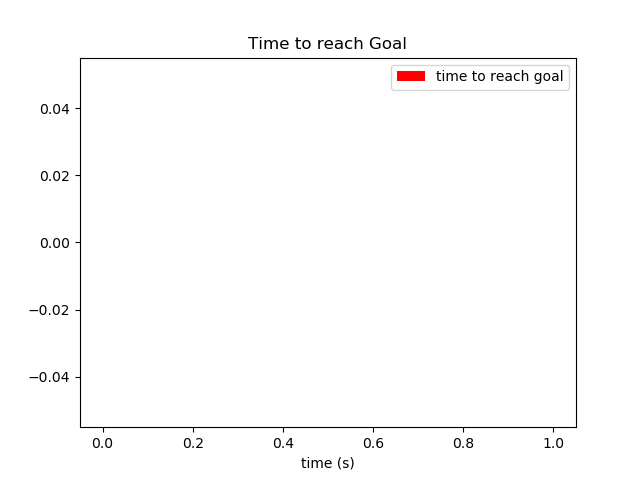

In [11]:
# setting the figure properties
fig4,ax4= plt.subplots()
ax4.hist(time_to_reach, 10, label='time to reach goal', color='red',lw=10)
ax4.legend()
ax4.set_title("Time to reach Goal")
ax4.set_xlabel('time (s)')

# function called to initialize the plot
def init4():
    ax4.hist(time_to_reach, 10, label='time to reach goal', color='red',lw=10)

# function called to update periodically the plot    
def animate4(i):
    global time_to_reach, ax4
    ax4.hist(time_to_reach,10, color='red',lw=10)
    
ani4=animation.FuncAnimation(fig4, animate4,init_func=init4, frames=100, interval=100, blit=True)



### Position and Orientation
In this block I have two figures: one to represent the robot position and one to represent the robot orientation. The first one represents the current robot position but also the past ones, we have a trajectory. Since it was decided to have arrays of maximum 500 elements we can see that the trajectory cancels itself after some time. If we wanted to save the entire trajectory we would have a very slow program, or we could decide to save points less frequently to have a smaller array, but this would create a less accurate trajectory.\
For the orientation plot I decided to represent the orientation as a single arrow. I implemented it on a new figure because in order to have only one arrow and not also the ones before I had to use the command ax6.clear that deletes everything. I could have cancelled the position and redrawn it each time but this would consist in a lot of delays and in the slowing down of the program.

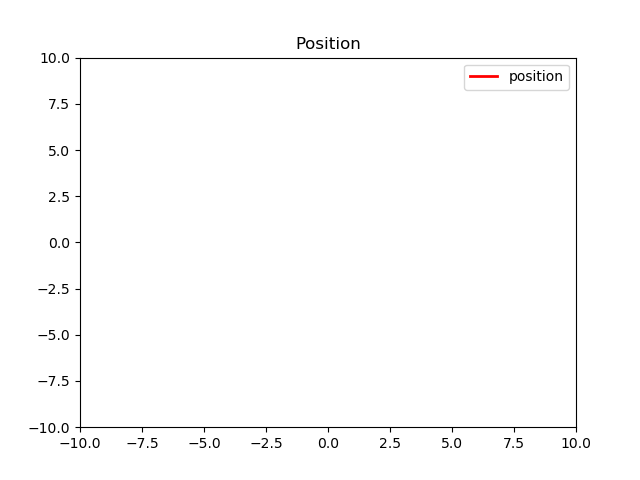

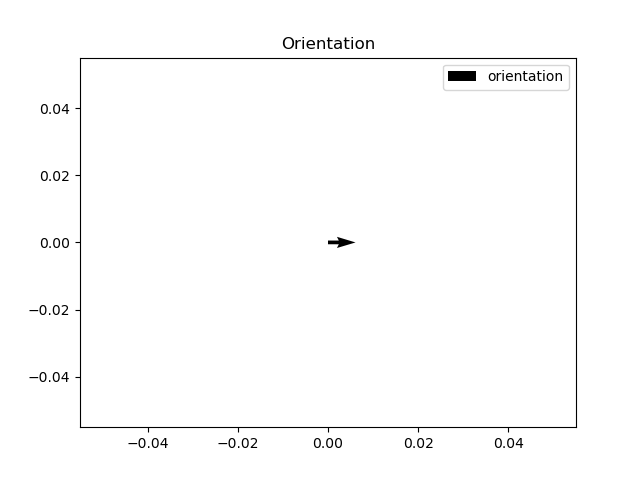

In [12]:
# setting the figure properties for figure 5 and 6
fig5,ax5=plt.subplots()
fig6,ax6=plt.subplots()
ax5.set_xlim((-10,10))
ax5.set_ylim((-10,10))
line5,=ax5.plot([],[], lw=2, color='red', label='position')
ax5.legend()
ax5.set_title("Position")
ax6.quiver(0,0,dx,dy,label='orientation')
ax6.legend()
ax6.set_title("Orientation")

# function called to initialize the plot
def init5():
    line5.set_data([],[])
    
# function called to initialize the plot
def init6():
    ax6.quiver(0,0,dx,dy,label='orientation')
    
# function called to update periodically the plot 
def animate5(i):
    global x_data, y_data
    line5.set_data(x_data, y_data)
    return (line5,)

# function called to update periodically the plot 
def animate6(i):
    ax6.clear()
    ax6.quiver(0,0,dx,dy,label='orientation')
    ax6.legend()
    ax6.set_title("Orientation")
    return (line5,)

ani5=animation.FuncAnimation(fig5, animate5, init_func=init5, frames=100, interval=100, blit=True)
ani6=animation.FuncAnimation(fig6, animate6, frames=1, interval=100, blit=True)